<a href="https://colab.research.google.com/github/AlexeyTri/Mathematics/blob/main/SVD_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Метод главных компонент

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Класс PCA

In [ ]:
class PCA:

  def __init__(self, n_components, solver='covariance'):
    self.n_components = n_components
    self.mean = None
    self.explained_variance = None
    self.solver = solver

  def fit(self, X):

    self.mean = np.mean(X, axis=0)

    if self.solver == 'covariance':
      covariances = (X - self.mean).T.dot((X - self.mean)) / (X.shape[0]-1)
      eigenvalues, eigenvectors = np.linalg.eig(covariances)

      idxs = np.argsort(eigenvalues)[::-1]
      eigenvalues = eigenvalues[idxs]
      eigenvectors = eigenvectors[idxs].T

    elif self.solver == 'svd':
      X = X - self.mean
      U, S, Vt = np.linalg.svd(X)

      eigenvalues, eigenvectors = S**2 / (X.shape[0]-1), Vt

    self.W = eigenvectors[:self.n_components]
    self.explained_variance = np.sum(eigenvalues[:self.n_components]) / np.sum(eigenvalues)

    return self

  def transform(self, X):

    X -= self.mean
    return np.dot(X, self.W.T)

  def transform_inverse(self, X):

    return np.dot(X, self.W) + self.mean

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target

from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

In [ ]:
pca = PCA(n_components=2, solver='covariance')
X_pca = pca.fit(X_std).transform(X_std)
print(X_pca.shape, pca.explained_variance)

(150, 2) 0.9581320720000165


In [ ]:
pca_svd = PCA(n_components=2, solver='svd')
X_pca_svd = pca_svd.fit(X_std).transform(X_std)
print(X_pca_svd.shape, pca_svd.explained_variance)

(150, 2) 0.9581320720000165


In [ ]:
np.allclose(X_pca, X_pca_svd)

True

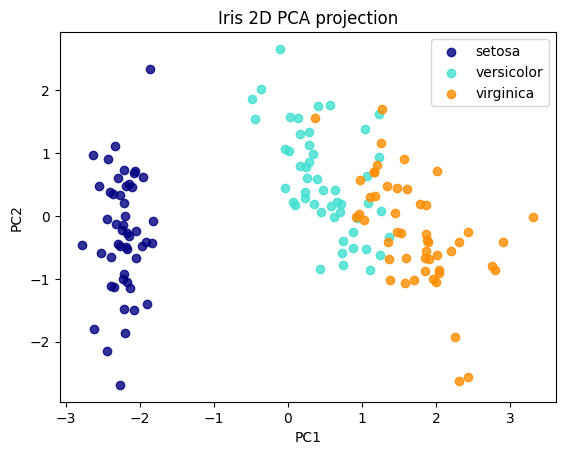

In [ ]:
plt.figure()
colors = ['navy', 'turquoise', 'darkorange']

for color, i, class_name in zip(colors, [0, 1, 2], iris.target_names):
  plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], color=color, alpha=0.8, label=class_name)
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title('Iris 2D PCA projection')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

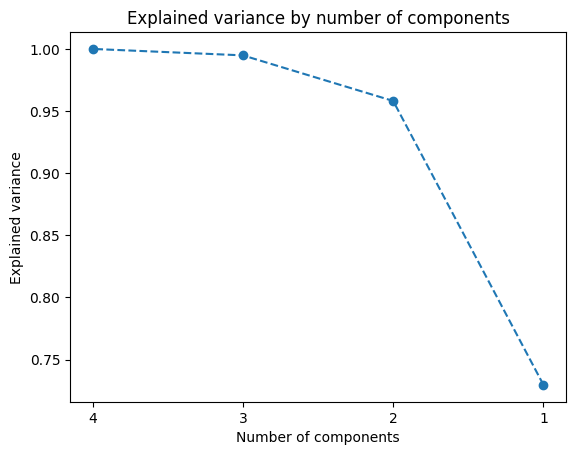

In [ ]:
components_range = range(1,5)
explained_vars = [PCA(n_components=i).fit(X_std).explained_variance for i in components_range]
plt.plot(components_range, explained_vars, '--o')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.xticks(components_range)
plt.gca().invert_xaxis()
plt.title('Explained variance by number of components')
plt.show()

In [ ]:
X_reconstructed = pca.transform_inverse(X_pca)
X_reconstructed[0], X_std[0]

(array([-0.99888895,  1.05319838, -1.30270654, -1.24709825]),
 array([-0.90068117,  1.01900435, -1.34022653, -1.3154443 ]))

In [ ]:
# данные совпадают при достаточно большом допустимом отклонении
np.allclose(X_reconstructed, X_std, atol=0.8)

True

## Метод собственных лиц

### Подготовка данных

In [ ]:
from sklearn.datasets import fetch_olivetti_faces
olivetti_faces = fetch_olivetti_faces()
X, y, images = olivetti_faces.data, olivetti_faces.target, olivetti_faces.images
X.shape, y.shape, images.shape

((400, 4096), (400,), (400, 64, 64))

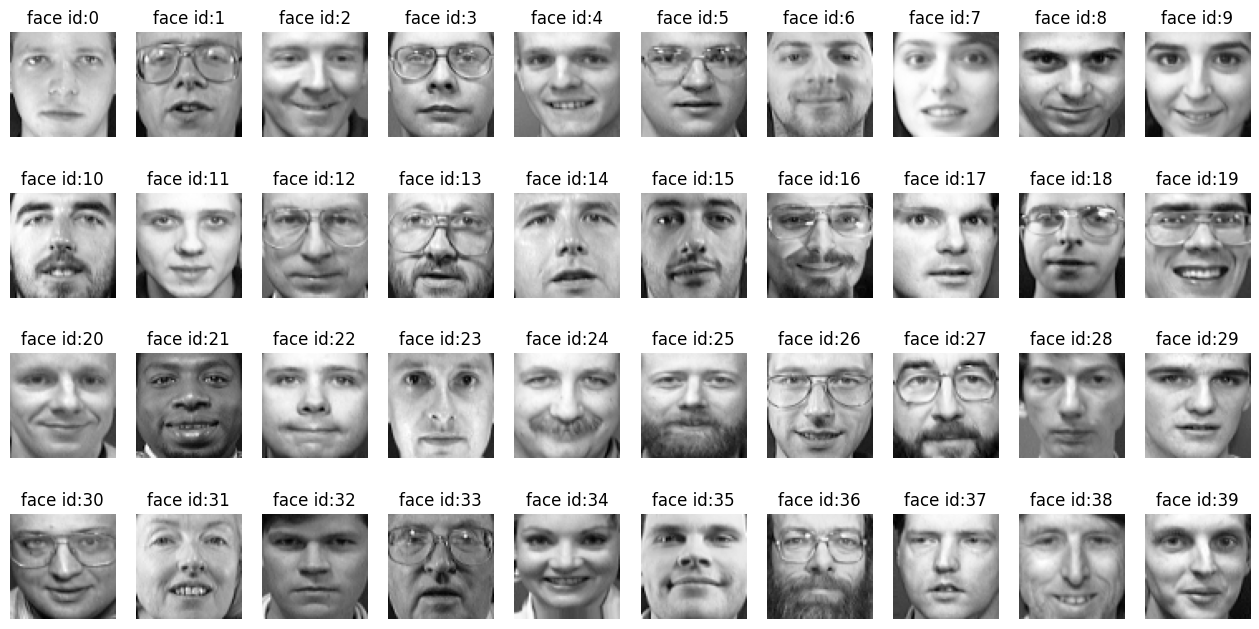

In [ ]:
fig, ax=plt.subplots(4, 10, figsize=(16, 8))
ax=ax.flatten()

for unique_id in np.unique(y):
  image_index=unique_id*10
  ax[unique_id].imshow(images[image_index], cmap='gray')
  ax[unique_id].axis('off')
  ax[unique_id].set_title(f'face id:{unique_id}')

plt.show()

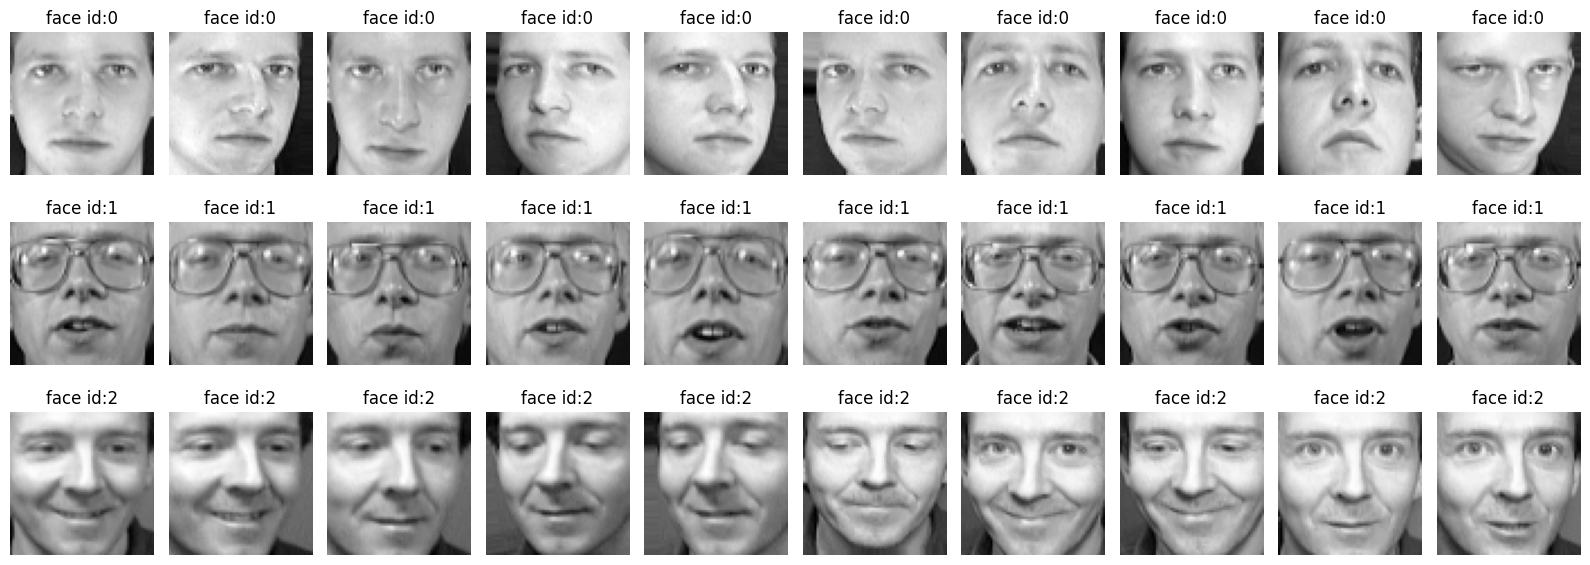

In [ ]:
rows, cols = 3, 10
fig, ax=plt.subplots(rows, cols, figsize=(16,6))

for i in range(rows):
  for j in range(cols):
    image_index=i*10 + j
    ax[i,j].imshow(images[image_index], cmap='gray')
    ax[i,j].axis('off')
    ax[i,j].set_title(f'face id:{i}')

plt.tight_layout()
plt.show()

In [ ]:
X_train, y_train, images_train = X[:389], y[:389], images[:389]
X_train.shape, y_train.shape, images_train.shape

((389, 4096), (389,), (389, 64, 64))

In [ ]:
X_test, y_test, images_test = X[-11:], y[-11:], images[-11:]
X_test.shape, y_test.shape, images_test.shape

((11, 4096), (11,), (11, 64, 64))

In [ ]:
np.unique(y_test, return_counts=True)

(array([38, 39]), array([ 1, 10]))

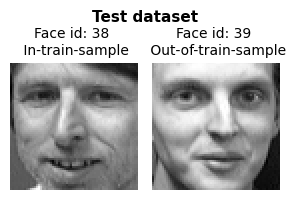

In [ ]:
fig = plt.figure(figsize = (3,2))
fig.suptitle('Test dataset', size=11, weight='bold')
ax1 = fig.add_subplot(121)
ax1.set_title(f'Face id: {y_test[0]} \n In-train-sample', {'fontsize' : 10})
ax1.imshow(images_test[0], cmap='gray')
ax1.axis('off')
ax2 = fig.add_subplot(122)
ax2.set_title(f'Face id: {y_test[1]} \n Out-of-train-sample', {'fontsize' : 10})
ax2.imshow(images_test[1], cmap='gray')
ax2.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
faceshape = images_train[0].shape
faceshape

(64, 64)

### Нахождение собственных лиц

In [ ]:
mean = np.mean(X_train, axis=0)
mean.shape

(4096,)

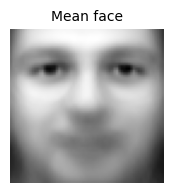

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(mean.reshape(faceshape), cmap='gray')
plt.title('Mean face', size=10)
plt.axis('off')
plt.show()

In [ ]:
X_centered = X_train - mean
covariance_matrix = (X_centered @ X_centered.T) / (X_centered.shape[0]-1)
covariance_matrix.shape

(389, 389)

In [ ]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
idxs = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idxs]
eigenvectors = eigenvectors[:,idxs]
eigenvectors_converted = X_centered.T @ eigenvectors
eigenvectors_converted.shape

(4096, 389)

In [ ]:
eigenvectors_converted = eigenvectors_converted.T / np.sqrt((eigenvectors_converted.T ** 2).sum(axis=1, keepdims=True))
eigenvectors_converted.shape

(389, 4096)

### Объсненная дисперсия

In [ ]:
total = sum(eigenvalues)

# найдем долю дисперсии, объясненную каждым из собственных значений
explained_variance = [(i / total) * 100 for i in eigenvalues]
explained_variance = np.round(explained_variance, 2)

# вычислим кумулятивную дисперсию первых n собственных значений
cumulative_explained_variance = np.cumsum(explained_variance)

# найдем количество компонент, которые объясняют не менее 90% дисперсии
variance_threshold = 90
n_components = np.argwhere(cumulative_explained_variance >=
                           variance_threshold).min()+1
print(n_components)

66


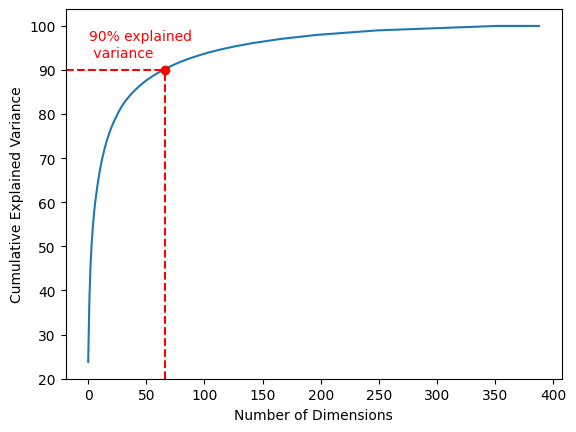

In [ ]:
plt.plot(cumulative_explained_variance)
plt.plot(n_components, variance_threshold, 'o', color='r')
plt.axhline(y=variance_threshold, xmax=0.2, linestyle='--', color='r')
plt.axvline(x=n_components, ymax=0.84, linestyle='--', color='r')
plt.text(0.5, 93, '90% explained \n variance', color='red')
plt.xlabel('Number of Dimensions')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [ ]:
eigenfaces = eigenvectors_converted[:n_components]
eigenfaces.shape

(66, 4096)

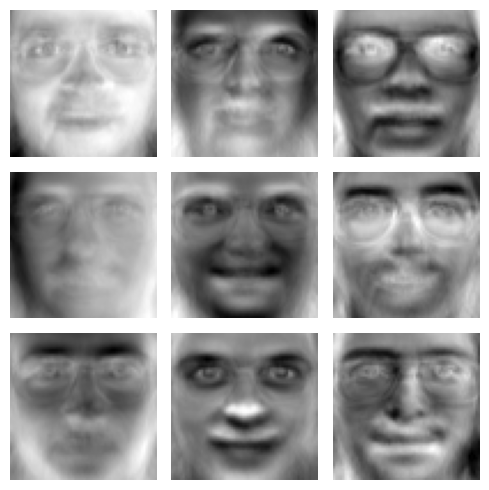

In [ ]:
fig, axes = plt.subplots(3,3,figsize=(5,5))
for i in range(9):
  axes[i%3][i//3].imshow(eigenfaces[i].reshape(faceshape), cmap='gray')
  axes[i%3][i//3].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
weights = eigenfaces @ (X_train - mean).T
weights.shape

(66, 389)

### Распознавание лиц

In-train-sample

In [ ]:
X_test[0].shape

(4096,)

In [ ]:
in_sample_query = X_test[0].reshape(1,-1)
in_sample_query_weight = eigenfaces @ (in_sample_query - mean).T
euclidean_distance = np.linalg.norm(weights - in_sample_query_weight, axis=0)
in_sample_best_match = np.argmin(euclidean_distance)
print(in_sample_best_match)

385


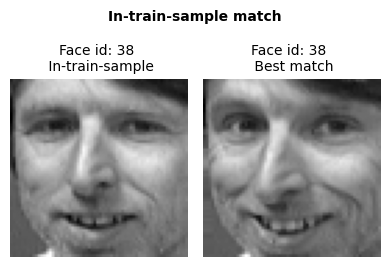

In [ ]:
fig = plt.figure(figsize = (4,3))
fig.suptitle('In-train-sample match', size = 10, weight='bold')
ax1 = fig.add_subplot(121)
ax1.set_title(f'Face id: {y_test[0]} \n In-train-sample', {'fontsize' : 10})
ax1.imshow(images_test[0], cmap='gray')
ax1.axis('off')
ax2 = fig.add_subplot(122)
ax2.set_title(f'Face id: {y_train[in_sample_best_match]} \n Best match', {'fontsize' : 10})
ax2.imshow(images_train[in_sample_best_match], cmap='gray')
ax2.axis('off')
plt.tight_layout()
plt.show()

Out-of-train-sample

In [ ]:
out_of_sample_query = X_test[1].reshape(1,-1)
out_of_sample_query_weight = eigenfaces @ (out_of_sample_query - mean).T
euclidean_distance = np.linalg.norm(weights - out_of_sample_query_weight, axis=0)
out_of_sample_best_match = np.argmin(euclidean_distance)
print(out_of_sample_best_match)

89


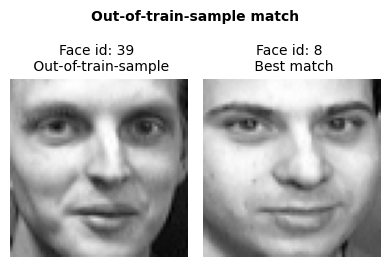

In [ ]:
fig = plt.figure(figsize = (4,3))
fig.suptitle('Out-of-train-sample match', size = 10, weight='bold')
ax1 = fig.add_subplot(121)
ax1.set_title(f'Face id: {y_test[1]} \n Out-of-train-sample', {'fontsize' : 10})
ax1.imshow(images_test[1], cmap='gray')
ax1.axis('off')
ax2 = fig.add_subplot(122)
ax2.set_title(f'Face id: {y_train[out_of_sample_best_match]} \n Best match', {'fontsize' : 10})
ax2.imshow(images_train[out_of_sample_best_match], cmap='gray')
ax2.axis('off')
plt.tight_layout()
plt.show()